In [9]:
import jax
import jax.numpy as jnp
import jax.random as jr
from jaxtyping import Array, Float, Int
import equinox as eqx

import matplotlib.pyplot as plt
import seaborn as sns

import equintk as nt
from typing import List



key = jr.PRNGKey(0)

In [10]:
class SirenLayer(eqx.Module):
    weight: jnp.ndarray
    bias: jnp.ndarray
    is_first: bool
    omega: float

    def __init__(self, in_features, out_features, *, key, is_first=False, omega=30.0):
        self.is_first = is_first
        self.omega = omega
        w_key, b_key = jr.split(key)

        if is_first:
            limit = 1 / in_features
        else:
            limit = jnp.sqrt(6 / in_features) / omega

        self.weight = jr.uniform(w_key, (out_features, in_features), minval=-limit, maxval=limit)
        self.bias = jr.uniform(b_key, (out_features,), minval=-limit, maxval=limit)

    def __call__(self, x):
        activation = self.omega * (x @ self.weight.T + self.bias)
        return jnp.sin(activation)


class Siren(eqx.Module):
    layers: List[SirenLayer]
    final_layer: eqx.nn.Linear

    def __init__(self, in_size, out_size, width_size, depth, *, key):
        keys = jr.split(key, depth + 1)
        self.layers = []

        self.layers.append(SirenLayer(in_size, width_size, key=keys[0], is_first=True))

        for i in range(1, depth):
            self.layers.append(SirenLayer(width_size, width_size, key=keys[i]))

        final_layer_key, w_key, b_key = jr.split(keys[depth], 3)

        self.final_layer = eqx.nn.Linear(width_size, out_size, key=final_layer_key)

        final_limit = jnp.sqrt(6 / width_size)
        siren_weight = jr.uniform(w_key, (out_size, width_size), minval=-final_limit, maxval=final_limit)
        siren_bias = jr.uniform(b_key, (out_size,), minval=-final_limit, maxval=final_limit)

        where = lambda layer: (layer.weight, layer.bias)
        replace = (siren_weight, siren_bias)
        self.final_layer = eqx.tree_at(where, self.final_layer, replace)

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return self.final_layer(x)



In [11]:
img = jnp.array(plt.imread("pxl.png"))

img = jax.image.resize(img, (16, 16, img.shape[-1]), method="linear")
img = img[..., :3]  # Drop alpha channel if present
print(f"{img.shape=}")


img.shape=(16, 16, 3)


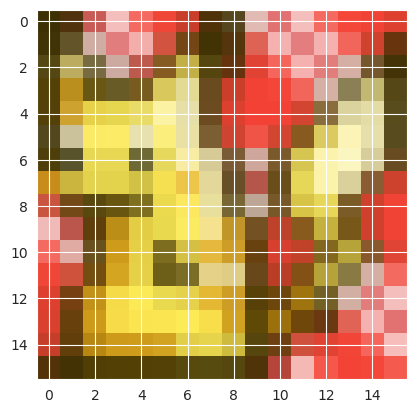

In [12]:
plt.imshow(img)

In [13]:
mlp = Siren(
    in_size=2,
    out_size=3,
    width_size=64,
    depth=4,
    key=jr.PRNGKey(42),
)

xs = jnp.stack(
    jnp.meshgrid(
        jnp.linspace(-1, 1, img.shape[0]),
        jnp.linspace(-1, 1, img.shape[1]),
        indexing="ij",
    ),
    axis=-1,
).reshape(-1, 2)
ys = img.reshape(-1, 3)
print(f"{xs.shape=}, {ys.shape=}")

xs.shape=(256, 2), ys.shape=(256, 3)


In [14]:
# y_pred = nt.ntk_predict(mlp, xs, ys, xs, 1)

In [15]:
# plt.imshow(y_pred.reshape(img.shape))

In [16]:
# @jax.jit
def take_mse(y_true, y_pred):
    return jnp.mean(
          jnp.square(
              y_true - y_pred)
    )


# mse = take_mse(ys, y_pred)

In [17]:
# print(f"{mse=}")

Text(0.5, 1.0, 'Monte Carlo NTK Prediction (proj_dim=1000)')

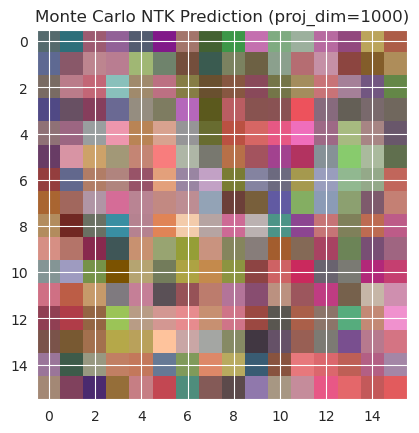

In [18]:
# Use higher projection dimension and better regularization for less noisy results
mc_y_pred = nt.mc_ntk_predict(mlp, jr.PRNGKey(0), xs, ys, xs, 1, proj_dim=1000, ridge=1e-4)
# Normalize the prediction to [0, 1] range for proper display
mc_y_pred_normalized = jnp.clip((mc_y_pred - mc_y_pred.min()) / (mc_y_pred.max() - mc_y_pred.min()), 0, 1)
plt.imshow(mc_y_pred_normalized.reshape(img.shape))
plt.title("Monte Carlo NTK Prediction (proj_dim=1000)")

In [19]:
mse = take_mse(ys, mc_y_pred)

In [20]:
mse

Array(0.10313271, dtype=float32)

Testing Monte Carlo NTK with different projection dimensions...
MSE with proj_dim=500: 0.2900620400905609
MSE with proj_dim=2000: 0.04891921207308769
Computing exact NTK for comparison...
Exact NTK MSE: 2.309071336914492e-12


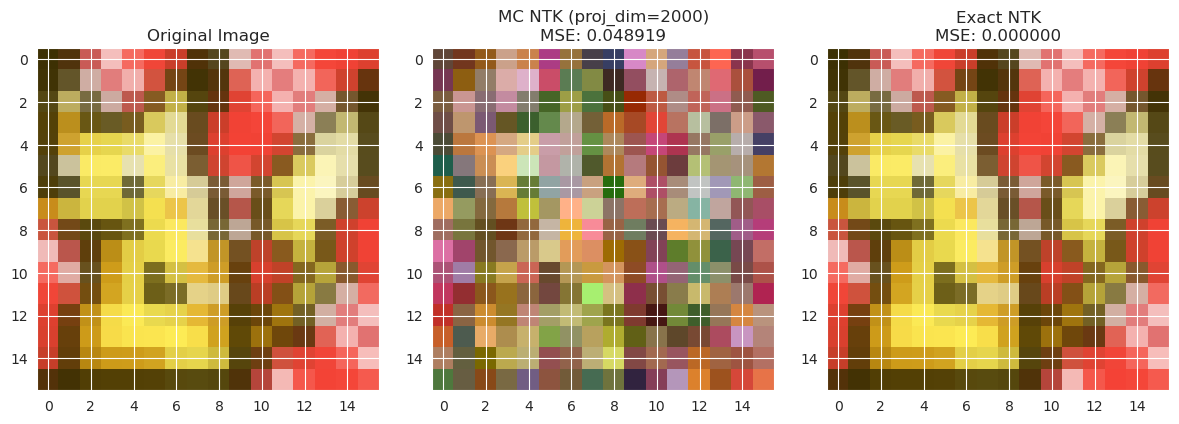

In [21]:
# Test the improved Monte Carlo NTK with different projection dimensions
print("Testing Monte Carlo NTK with different projection dimensions...")

# Test with proj_dim=500
mc_y_pred_500 = nt.mc_ntk_predict(mlp, jr.PRNGKey(0), xs, ys, xs, 1, proj_dim=500, ridge=1e-4)
mse_500 = take_mse(ys, mc_y_pred_500)
print(f"MSE with proj_dim=500: {mse_500}")

# Test with proj_dim=2000
mc_y_pred_2000 = nt.mc_ntk_predict(mlp, jr.PRNGKey(0), xs, ys, xs, 1, proj_dim=2000, ridge=1e-4)
mse_2000 = take_mse(ys, mc_y_pred_2000)
print(f"MSE with proj_dim=2000: {mse_2000}")

# Normalize and display the best result
mc_y_pred_normalized = jnp.clip((mc_y_pred_2000 - mc_y_pred_2000.min()) / (mc_y_pred_2000.max() - mc_y_pred_2000.min()), 0, 1)
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("Original Image")

plt.subplot(1, 3, 2)
plt.imshow(mc_y_pred_normalized.reshape(img.shape))
plt.title(f"MC NTK (proj_dim=2000)\nMSE: {mse_2000:.6f}")

# For comparison, let's also test the exact NTK if memory allows
try:
    print("Computing exact NTK for comparison...")
    exact_y_pred = nt.ntk_predict(mlp, xs, ys, xs, 1)
    exact_mse = take_mse(ys, exact_y_pred)
    print(f"Exact NTK MSE: {exact_mse}")

    plt.subplot(1, 3, 3)
    plt.imshow(exact_y_pred.reshape(img.shape))
    plt.title(f"Exact NTK\nMSE: {exact_mse:.6f}")
except Exception as e:
    print(f"Exact NTK computation failed (likely memory): {e}")
    plt.subplot(1, 3, 3)
    plt.text(0.5, 0.5, "Exact NTK\n(memory limited)", ha='center', va='center', transform=plt.gca().transAxes)

plt.tight_layout()
plt.show()

Testing corrected Monte Carlo NTK implementation...
MSE with proj_dim=100: 433.632080078125
MSE with proj_dim=500: 0.2900620400905609
MSE with proj_dim=1000: 0.1031327098608017
MSE with proj_dim=2000: 0.04891921207308769
Exact NTK MSE: 2.309071336914492e-12


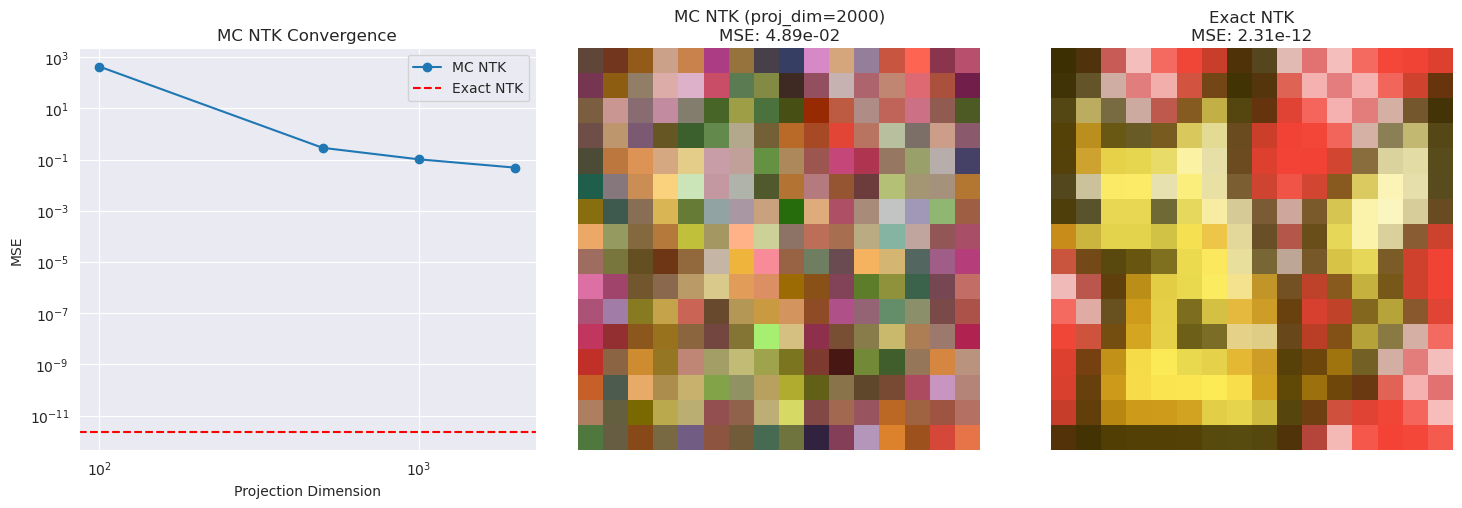


Improvement: MC NTK MSE went from 4.34e+02 to 4.89e-02
Exact NTK MSE: 2.31e-12
Ratio (MC/Exact): 21185665024.0


In [24]:
# Test the corrected Monte Carlo NTK implementation
print("Testing corrected Monte Carlo NTK implementation...")

# Test with different projection dimensions to see convergence
proj_dims = [100, 500, 1000, 2000]
mse_results = []

for proj_dim in proj_dims:
    mc_y_pred_test = nt.mc_ntk_predict(mlp, jr.PRNGKey(0), xs, ys, xs, 1, proj_dim=proj_dim, ridge=1e-6)
    mse_test = take_mse(ys, mc_y_pred_test)
    mse_results.append(mse_test)
    print(f"MSE with proj_dim={proj_dim}: {mse_test}")

# Also compute exact NTK for comparison
exact_y_pred = nt.ntk_predict(mlp, xs, ys, xs, 1, ridge=1e-6)
exact_mse = take_mse(ys, exact_y_pred)
print(f"Exact NTK MSE: {exact_mse}")

# Plot convergence
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.loglog(proj_dims, mse_results, 'o-', label='MC NTK')
plt.axhline(y=exact_mse, color='r', linestyle='--', label='Exact NTK')
plt.xlabel('Projection Dimension')
plt.ylabel('MSE')
plt.title('MC NTK Convergence')
plt.legend()
plt.grid(True)

# Visual comparison with best MC result
best_mc_y_pred = nt.mc_ntk_predict(mlp, jr.PRNGKey(0), xs, ys, xs, 1, proj_dim=2000, ridge=1e-4)
best_mc_mse = take_mse(ys, best_mc_y_pred)

plt.subplot(1, 3, 2)
best_mc_normalized = jnp.clip((best_mc_y_pred - best_mc_y_pred.min()) / (best_mc_y_pred.max() - best_mc_y_pred.min()), 0, 1)
plt.imshow(best_mc_normalized.reshape(img.shape))
plt.title(f"MC NTK (proj_dim=2000)\nMSE: {best_mc_mse:.2e}")
plt.axis('off')

plt.subplot(1, 3, 3)
plt.imshow(exact_y_pred.reshape(img.shape))
plt.title(f"Exact NTK\nMSE: {exact_mse:.2e}")
plt.axis('off')

plt.tight_layout()
plt.show()

print(f"\nImprovement: MC NTK MSE went from {mse_results[0]:.2e} to {best_mc_mse:.2e}")
print(f"Exact NTK MSE: {exact_mse:.2e}")
print(f"Ratio (MC/Exact): {best_mc_mse/exact_mse:.1f}")